# Mention Detection using SciBERT as feature encoder

- The goal in this notebook is to extract the entities from the free text

- We just want to tell whether the token is entity or not

- The result from this notebook is to be used for the second Stage of Entity Linking where we take the detected entities from here and disambiguate them in Knowledge base

In [1]:
%%capture

!pip install seqeval

import json
import csv
import copy

import numpy as np
import pandas as pd
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.layers import Input, Bidirectional, Dense, LSTM, TimeDistributed, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.backend as K

from seqeval.metrics import classification_report, f1_score, accuracy_score
from seqeval.metrics.sequence_labeling import get_entities
from seqeval.scheme import IOB2

from transformers import BertTokenizer, BertConfig, TFBertModel

Starting TPU environment

In [2]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Reading the data (sequences, labels) and build detection labels from the recognition labels

In [3]:
def reformat_data(data_file):
    with open(data_file, 'r') as file:
        article_sentences, article_labels = [], []
        sentence_tokens, sentence_labels = [], []
        
        for line in file.readlines():
            if line == '\n':
                if sentence_labels != []:
                    article_sentences.append(sentence_tokens)
                    article_labels.append(sentence_labels)
                    sentence_tokens, sentence_labels = [], []
            else:
                token = line.split(" ")[0]
                label = line.split(" ")[1][:-1]
                sentence_tokens.append(token)
                sentence_labels.append(label)
        
        article_sentences.append(sentence_tokens)
        article_labels.append(sentence_labels)
                
    return article_sentences, article_labels
    
train_sentences, train_recog_labels = reformat_data("../input/thesis/st21pv_training_and_validation.txt")
test_sentences, test_recog_labels = reformat_data("../input/thesis/st21pv_testing.txt")

In [4]:
def build_detection_labels(recog_labels):
    detect_labels = []
    for seq_labels in recog_labels:
        labels = []
        for label in seq_labels:
            if label == "O":
                labels.append("O")
            else:
                labels.append(label[:2]+"Entity")
        detect_labels.append(labels)
    
    return detect_labels

train_detect_labels = build_detection_labels(train_recog_labels)
test_detect_labels = build_detection_labels(test_recog_labels)

This is to build dictionary for the labels

In [6]:
label_dict = {'O': 0, 'B-Entity': 1, 'I-Entity': 2}
inv_label_map = {v: k for k, v in label_dict.items()}

## Tokenization using SciBERT pretrained Tokenizer

In [7]:
scibert_tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/228k [00:00<?, ?B/s]

The tokenizer has vocab size of 28996. The tokenizer has special tokens for begin of sentence [CLS] and end of sentence [SEP] and [PAD]. The token [UNK] is used when the tokenizer can't recognize the word

In [8]:
scibert_tokenizer

PreTrainedTokenizer(name_or_path='allenai/scibert_scivocab_uncased', vocab_size=31090, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

This is add special tokens [CLS] and [SEP]. The token [CLS] at the start of each sentence and [SEP] at the end of each sentence, This is the way that BERT model has been trained on and it expect the input data to be in this way in order to know where is the start and end of each sentence

In [9]:
for i, sample_sent in enumerate(train_sentences):
    marked_sent = ["[CLS]"]
    marked_sent.extend(sample_sent)
    marked_sent.append("[SEP]")
    train_sentences[i] = marked_sent

for i, sample_sent in enumerate(test_sentences):
    marked_sent = ["[CLS]"]
    marked_sent.extend(sample_sent)
    marked_sent.append("[SEP]")
    test_sentences[i] = marked_sent

The special tokens [CLS] and [SEP] are labled with 'O' tag

In [10]:
for i, labels in enumerate(train_detect_labels):
    marked_labels = ["O"]
    marked_labels.extend(labels)
    marked_labels.append("O")
    train_detect_labels[i] = marked_labels

for i, labels in enumerate(test_detect_labels):
    marked_labels = ["O"]
    marked_labels.extend(labels)
    marked_labels.append("O")
    test_detect_labels[i] = marked_labels
    
for i, labels in enumerate(train_recog_labels):
    marked_labels = ["O"]
    marked_labels.extend(labels)
    marked_labels.append("O")
    train_recog_labels[i] = marked_labels

for i, labels in enumerate(test_recog_labels):
    marked_labels = ["O"]
    marked_labels.extend(labels)
    marked_labels.append("O")
    test_recog_labels[i] = marked_labels

The way that BERT model tokenize words is by break the word into several subwords or WordPiece tokenization (Wu et al.,2016) and assign a uninque token for each subword. 

In [11]:
print(scibert_tokenizer.encode('I-Macroaggregated Albumin')[1:-1])
test = scibert_tokenizer.tokenize('I-Macroaggregated Albumin')
print(test)
print(scibert_tokenizer.convert_tokens_to_ids(test))

[259, 579, 7183, 16881, 224, 9804]
['i', '-', 'macro', '##aggreg', '##ated', 'albumin']
[259, 579, 7183, 16881, 224, 9804]


The following is used to tokenize each word after breaking it into subwords. We only set the first word with the original label and the rest following subwords, we assign the "O" label to them. This is following the original BERT article: https://arxiv.org/pdf/1810.04805.pdf)

In [12]:
def tokenize_and_preserve_labels(sentence, detect_labels, recog_labels):
    tokenized_sentence = []
    det_labels = []
    rec_labels = []
    masks = []
    
    for word, detect_label, recog_label in zip(sentence, detect_labels, recog_labels):

        tokenized_word = scibert_tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        tokenized_sentence.extend(tokenized_word)
        
        if n_subwords <= 1:
            det_labels.extend([detect_label]*n_subwords) 
            rec_labels.extend([recog_label]*n_subwords)
            masks.extend([1]*n_subwords)
        else:
            det_labels.extend([detect_label]+["O"]*(n_subwords-1))
            rec_labels.extend([recog_label]+["O"]*(n_subwords-1))
            masks.extend([1]+[0]*(n_subwords-1))
    return tokenized_sentence, det_labels, rec_labels, masks

In [13]:
tokenized_train_texts_and_labels = [
    tokenize_and_preserve_labels(sent, det_labs, rec_labs)
    for sent, det_labs, rec_labs in zip(tqdm(train_sentences), train_detect_labels, train_recog_labels)
]
tokenized_test_texts_and_labels = [
    tokenize_and_preserve_labels(sent, det_labs, rec_labs)
    for sent, det_labs, rec_labs in zip(tqdm(test_sentences), test_detect_labels, test_recog_labels)
]

100%|██████████| 8687/8687 [00:22<00:00, 386.05it/s]


In [14]:
tokenized_train_texts = [token_label_pair[0] for token_label_pair in tokenized_train_texts_and_labels]
train_detect_labels = [token_label_pair[1] for token_label_pair in tokenized_train_texts_and_labels]
train_recog_labels = [token_label_pair[2] for token_label_pair in tokenized_train_texts_and_labels]
train_masks = [token_label_pair[3] for token_label_pair in tokenized_train_texts_and_labels]

tokenized_test_texts = [token_label_pair[0] for token_label_pair in tokenized_test_texts_and_labels]
test_detect_labels = [token_label_pair[1] for token_label_pair in tokenized_test_texts_and_labels]
test_recog_labels = [token_label_pair[2] for token_label_pair in tokenized_test_texts_and_labels]
test_masks = [token_label_pair[3] for token_label_pair in tokenized_test_texts_and_labels]

## Padding

In [15]:
def text_stats():
    tokens_dict = {}
    lengths = []
    i = 0
    for txt in [tokenized_test_texts_and_labels, tokenized_train_texts_and_labels]:
        for sentence in txt:
            lengths.append(len(sentence[0]))
            for word in np.unique(sentence[0]):
                if word.lower() not in tokens_dict.keys():
                    i+=1
                    tokens_dict[word.lower()] = i
                    
    return tokens_dict, np.max(lengths)
            
tokens_dict, maxlen = text_stats()

print("Maximum length of the sentences after breaking words into subwords is: ", maxlen)

Maximum length of the sentences after breaking words into subwords is:  293


This is to pad all senteneces with zeros into the maximum length

In [16]:
train_ids = sequence.pad_sequences([scibert_tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_train_texts],
                          maxlen=maxlen, dtype="long", value=0.0,
                          truncating="post", padding="post")

train_labels = sequence.pad_sequences([[label_dict.get(l) for l in lab] for lab in train_detect_labels], 
                             maxlen=maxlen, value=label_dict["O"], padding="post", 
                             dtype="long", truncating="post")

test_ids = sequence.pad_sequences([scibert_tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_test_texts],
                          maxlen=maxlen, dtype="long", value=0.0,
                          truncating="post", padding="post")

test_labels = sequence.pad_sequences([[label_dict.get(l) for l in lab] for lab in test_detect_labels],
                     maxlen=maxlen, value=label_dict["O"], padding="post",
                     dtype="long", truncating="post")

test_mask = sequence.pad_sequences([[l for l in lab] for lab in test_masks],
                     maxlen=maxlen, value=label_dict["O"], padding="post",
                     dtype="long", truncating="post")

train_mask = sequence.pad_sequences([[l for l in lab] for lab in train_masks], 
                             maxlen=maxlen, value=label_dict["O"], padding="post", 
                             dtype="long", truncating="post")

This is used to convert the lebels into one hot encoded labels

In [17]:
train_labels_ohe = [to_categorical(i, num_classes=3) for i in train_labels]
test_labels_ohe = [to_categorical(i, num_classes=3) for i in test_labels]

Now we cast sequences, labels and masks into tensors

In [18]:
train_seq = train_ids
test_seq = test_ids
train_seq = tf.cast(train_seq, tf.float32) 
test_seq = tf.cast(test_seq, tf.float32)
train_labels = tf.cast(train_labels_ohe, tf.float32)
test_labels = tf.cast(test_labels_ohe, tf.float32)
train_mask = tf.cast(train_mask, tf.float32)
test_mask = tf.cast(test_mask, tf.float32)

In [19]:
print(train_seq.shape)
print(train_mask.shape)
print(train_labels.shape)
print(test_seq.shape)
print(test_mask.shape)
print(test_labels.shape)

(34830, 293)
(34830, 293)
(34830, 293, 3)
(8687, 293)
(8687, 293)
(8687, 293, 3)


## Evaluation Metrics

Evaluation metrics, The mask is to make sure that the 'O' token was not taken into account when calculating the metrics

In [20]:
def mask(m, q):
    mask = tf.math.reduce_any(tf.not_equal(m, q), axis=-1)
    return mask

def recall(y_true, y_pred):
    pad = tf.constant([1., 0., 0.], dtype=tf.float32)
    mask_ = mask(y_true, pad)
    masked_y_true = tf.boolean_mask(y_true, mask_)
    masked_y_pred = tf.boolean_mask(y_pred, mask_)
    true_positives = K.sum(K.round(K.clip(masked_y_true * masked_y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(masked_y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    pad = tf.constant([1., 0., 0.], dtype=tf.float32)
    mask_ = mask(y_true, pad)
    masked_y_true = tf.boolean_mask(y_true, mask_)
    masked_y_pred = tf.boolean_mask(y_pred, mask_)
    true_positives = K.sum(K.round(K.clip(masked_y_true * masked_y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(masked_y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1(y_true, y_pred):
    precision_ = precision(y_true, y_pred)
    recall_ = recall(y_true, y_pred)
    return 2*((precision_*recall_)/(precision_+recall_+K.epsilon()))

Important Notes about the following network

- We take the last four layer hidden states (embeddings) of the BERT model and take average of them before feeding them into the Bi-LSTM layer.  (reference: BERT paper https://arxiv.org/pdf/1810.04805.pdf)

- The number of labels to be predicted are 3

- The BERT model is freezed while training 

In [21]:
def build_bert_lstm_model():
    encoder = TFBertModel.from_pretrained("allenai/scibert_scivocab_uncased", 
                                          output_hidden_states=True, 
                                          from_pt=True, name='SciBERT')
    encoder.bert.trainable = False

    input_ids = Input(shape=(maxlen,), dtype=tf.int32, name="Input Ids")
    mask = Input(shape=(maxlen,), dtype=tf.int32, name="Input Mask")
    outputs = encoder(input_ids, attention_mask=mask)
    
    #  get last four layers (reference: BERT paper https://arxiv.org/pdf/1810.04805.pdf)
    last_four_layers = [outputs.hidden_states[i] for i in (-1, -2, -3, -4)]
    # sum them element wise
    sum_hidden_states = tf.math.add_n(last_four_layers)
    # take the mean of the vector 
    avg_emb = tf.math.scalar_mul(1/4, sum_hidden_states)
    
    #concat = tf.concat(last_four_layers, axis=-1)
    
    outputs = Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.4, recurrent_dropout=0.4), 
                            merge_mode = 'concat', name='Bi-LSTM')(avg_emb)
    
    outputs = LSTM(units=128, dropout=0.4,  return_sequences=True, recurrent_dropout=0.4, name='LSTM')(outputs)
    
    outputs = (TimeDistributed(Dense(128, activation="relu"), name='TimeDistributed'))(outputs)

    outputs = (Dense(len(label_dict), activation="softmax", name='Output-Layer'))(outputs)

    bert_lstm = Model([input_ids, mask], outputs)
    
    bert_lstm.compile(loss="CategoricalCrossentropy",
                      metrics=[f1, precision, recall], 
                      optimizer=tf.keras.optimizers.Adam(0.0008))
    
    return bert_lstm

- Start the model with the TPU environment we started earlier

- Here we build validation data for each cross validation by slicing the original train data in order to provide different validation data for each KFold

In [22]:
tf.random.set_seed(42)
val_history = {}
for k_fold in tqdm(range(3)):
    X_val, mask_val, y_val = (train_seq[k_fold*10000:k_fold*10000+10000], 
                                    train_mask[k_fold*10000:k_fold*10000+10000], 
                                    train_labels[k_fold*10000:k_fold*10000+10000])
    
    if k_fold == 0:
        X_train, mask_train, y_train = (train_seq[k_fold*10000+10000:], 
                                  train_mask[k_fold*10000+10000:], 
                                  train_labels[k_fold*10000+10000:])
    else:
        X_train, mask_train, y_train = (tf.concat([train_seq[:k_fold*10000], train_seq[k_fold*10000+10000:]], axis=0), 
                                        tf.concat([train_mask[:k_fold*10000], train_mask[k_fold*10000+10000:]], axis=0),
                                        tf.concat([train_labels[:k_fold*10000], train_labels[k_fold*10000+10000:]], axis=0))

    with tpu_strategy.scope(): 
        bert_lstm_model = build_bert_lstm_model()
        #bert_lstm_model.summary()
        val_history["bert_lstm_his{0}".format(k_fold)] = bert_lstm_model.fit((X_train, mask_train), y_train, 
                                        epochs = 30 , batch_size = 64, 
                                        validation_data = ((X_val, mask_val), y_val), verbose=0)

  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

100%|██████████| 3/3 [53:29<00:00, 1069.70s/it]


We tried the following hyperparameters:

LR : (0.001, 0.002, 0.0005, 0.0008, 0.001, 0.005), units: (64, 128)

Notice the evaluation metrics that are used here are not strict mode. 

In [23]:
loss_plot = [[val_history["bert_lstm_his"+str(i)].history['loss'] for i in range(3)], 'Training Loss']
f1_plot = [[val_history["bert_lstm_his"+str(i)].history['f1'] for i in range(3)], 'Training F1']
val_loss_plot = [[val_history["bert_lstm_his"+str(i)].history['val_loss'] for i in range(3)], 'Validation Loss']
val_f1_plot = [[val_history["bert_lstm_his"+str(i)].history['val_f1'] for i in range(3)], 'Validation F1']
val_precision_plot = [[val_history["bert_lstm_his"+str(i)].history['val_precision'] for i in range(3)], 'Validation Precision']
precision_plot = [[val_history["bert_lstm_his"+str(i)].history['precision'] for i in range(3)], 'Training Precision']
recall_plot = [[val_history["bert_lstm_his"+str(i)].history['recall'] for i in range(3)], 'Training Recall']
val_recall_plot = [[val_history["bert_lstm_his"+str(i)].history['val_recall'] for i in range(3)], 'Validation Recall']

In [24]:
import math
import matplotlib.pyplot as plt
def make_plot(metric, val_metric, ylabel):
    epochs = range(1, 31)
    xint = range(min(epochs)+1, math.ceil(max(epochs))+1, 2)

    plt.figure(figsize=(25,15))
    plt.plot(epochs, metric[0][0],  label=metric[1], linewidth=4, c="#0000FF", )
    plt.plot(epochs, val_metric[0][0], label=val_metric[1], linewidth=4, c="#FFA500")
    plt.plot(epochs, metric[0][1],  linewidth=4, c="#0000FF", )
    plt.plot(epochs, val_metric[0][1], linewidth=4, c="#FFA500")
    plt.plot(epochs, metric[0][2],  linewidth=4, c="#0000FF", )
    plt.plot(epochs, val_metric[0][2],  linewidth=4, c="#FFA500")
    plt.xlabel('Epochs', fontsize=50)
    plt.ylabel(ylabel, fontsize=50)
    plt.legend(fontsize=50)
    plt.xticks(xint, fontsize=50)
    plt.yticks(fontsize=50)
    plt.grid()
    plt.tight_layout()
    plt.savefig(metric[1]+'.pdf')
    plt.show()

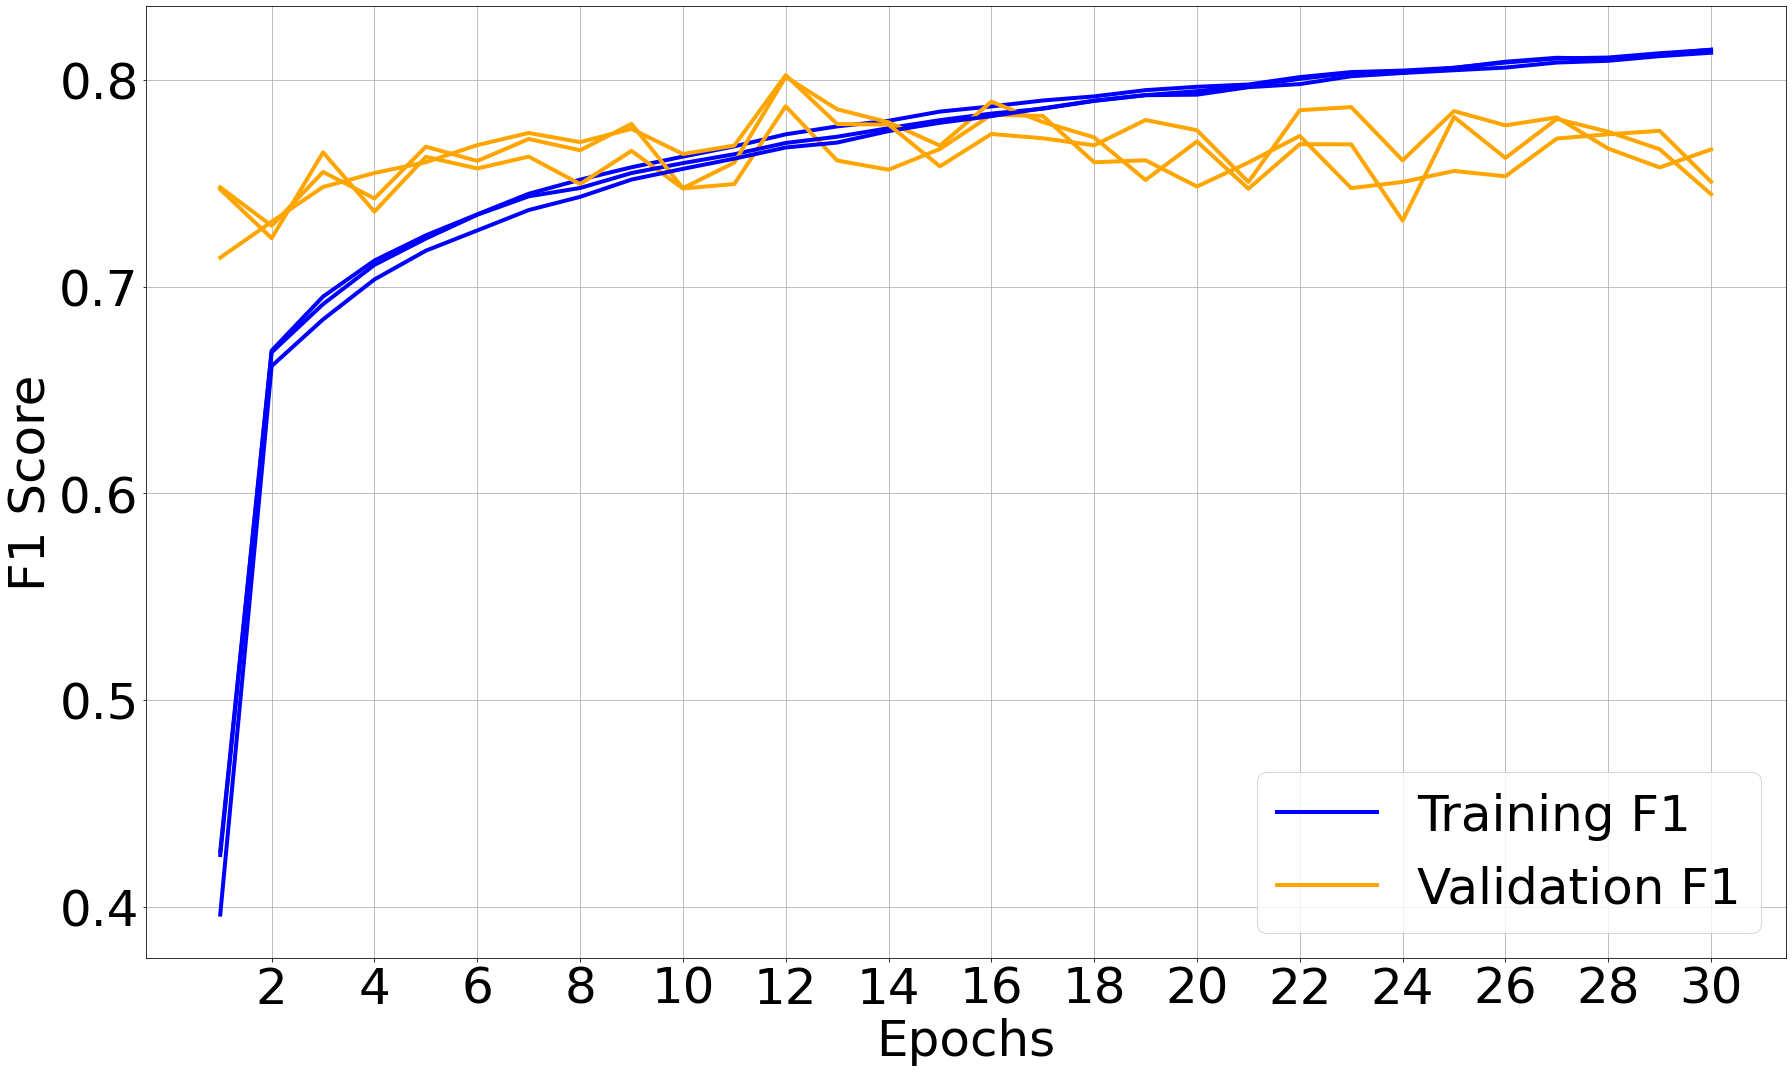

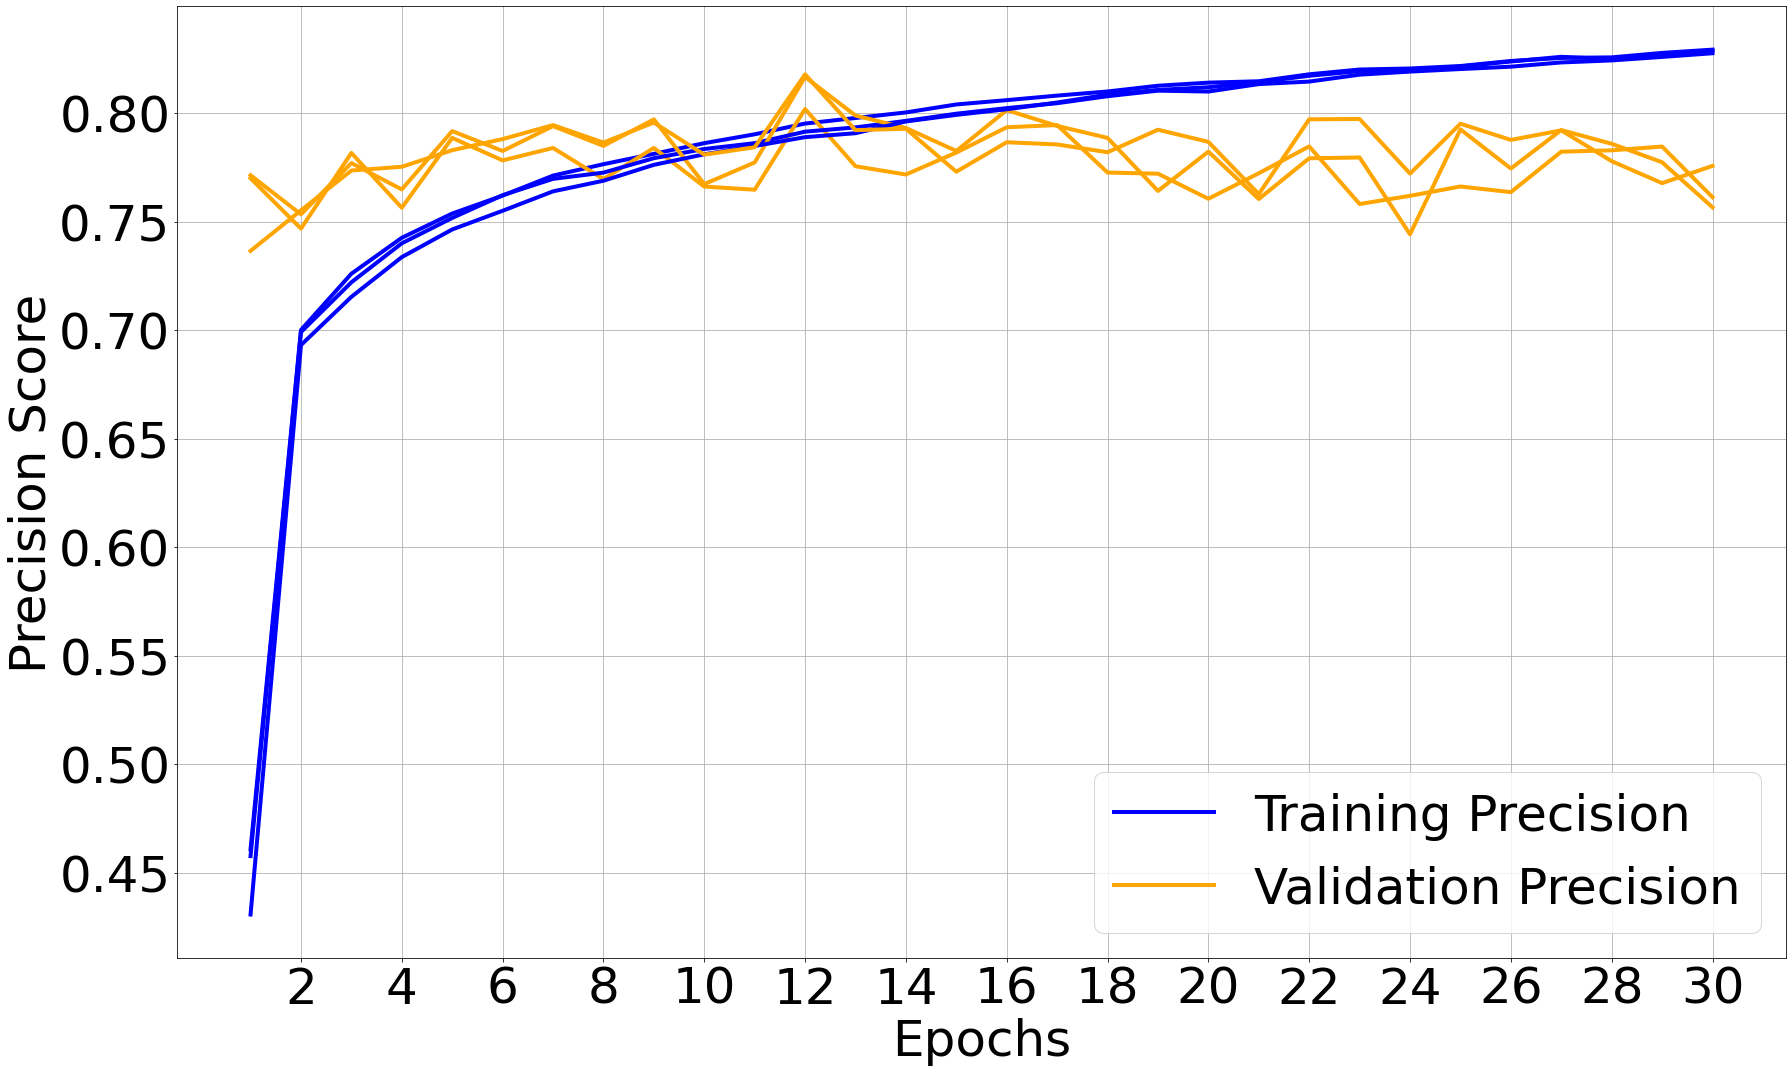

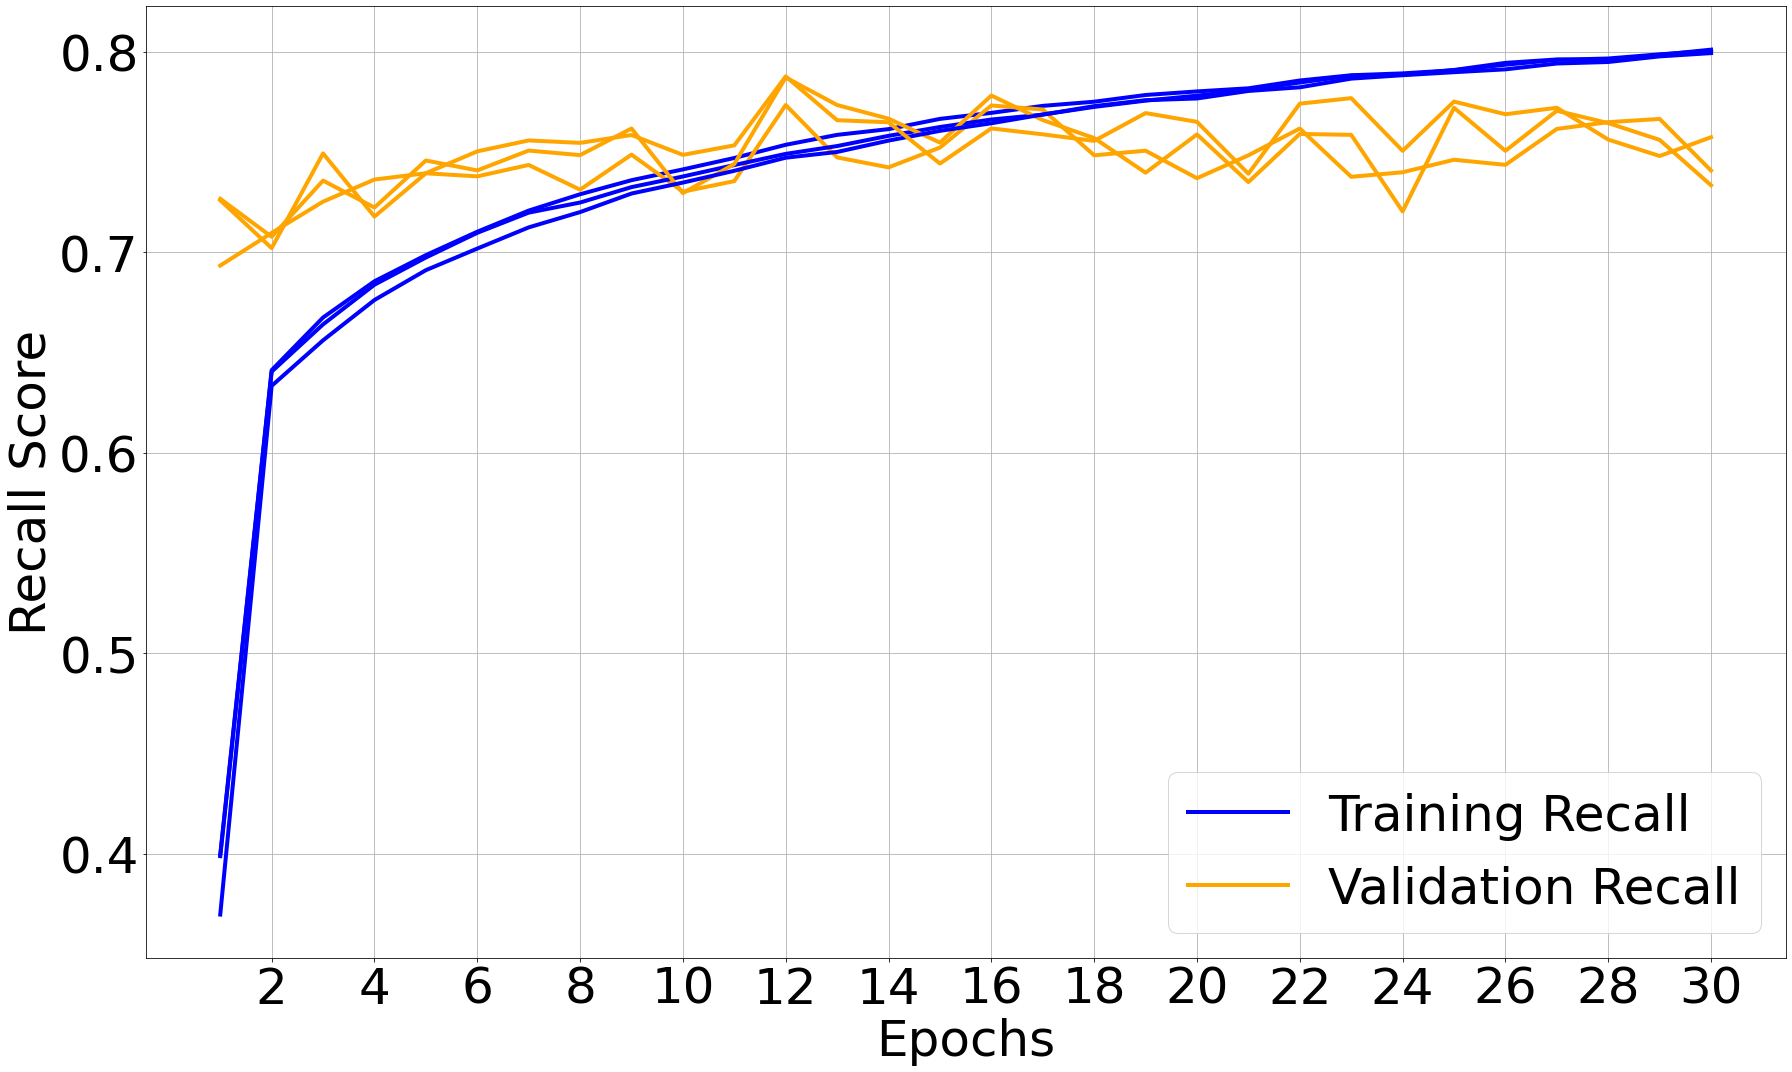

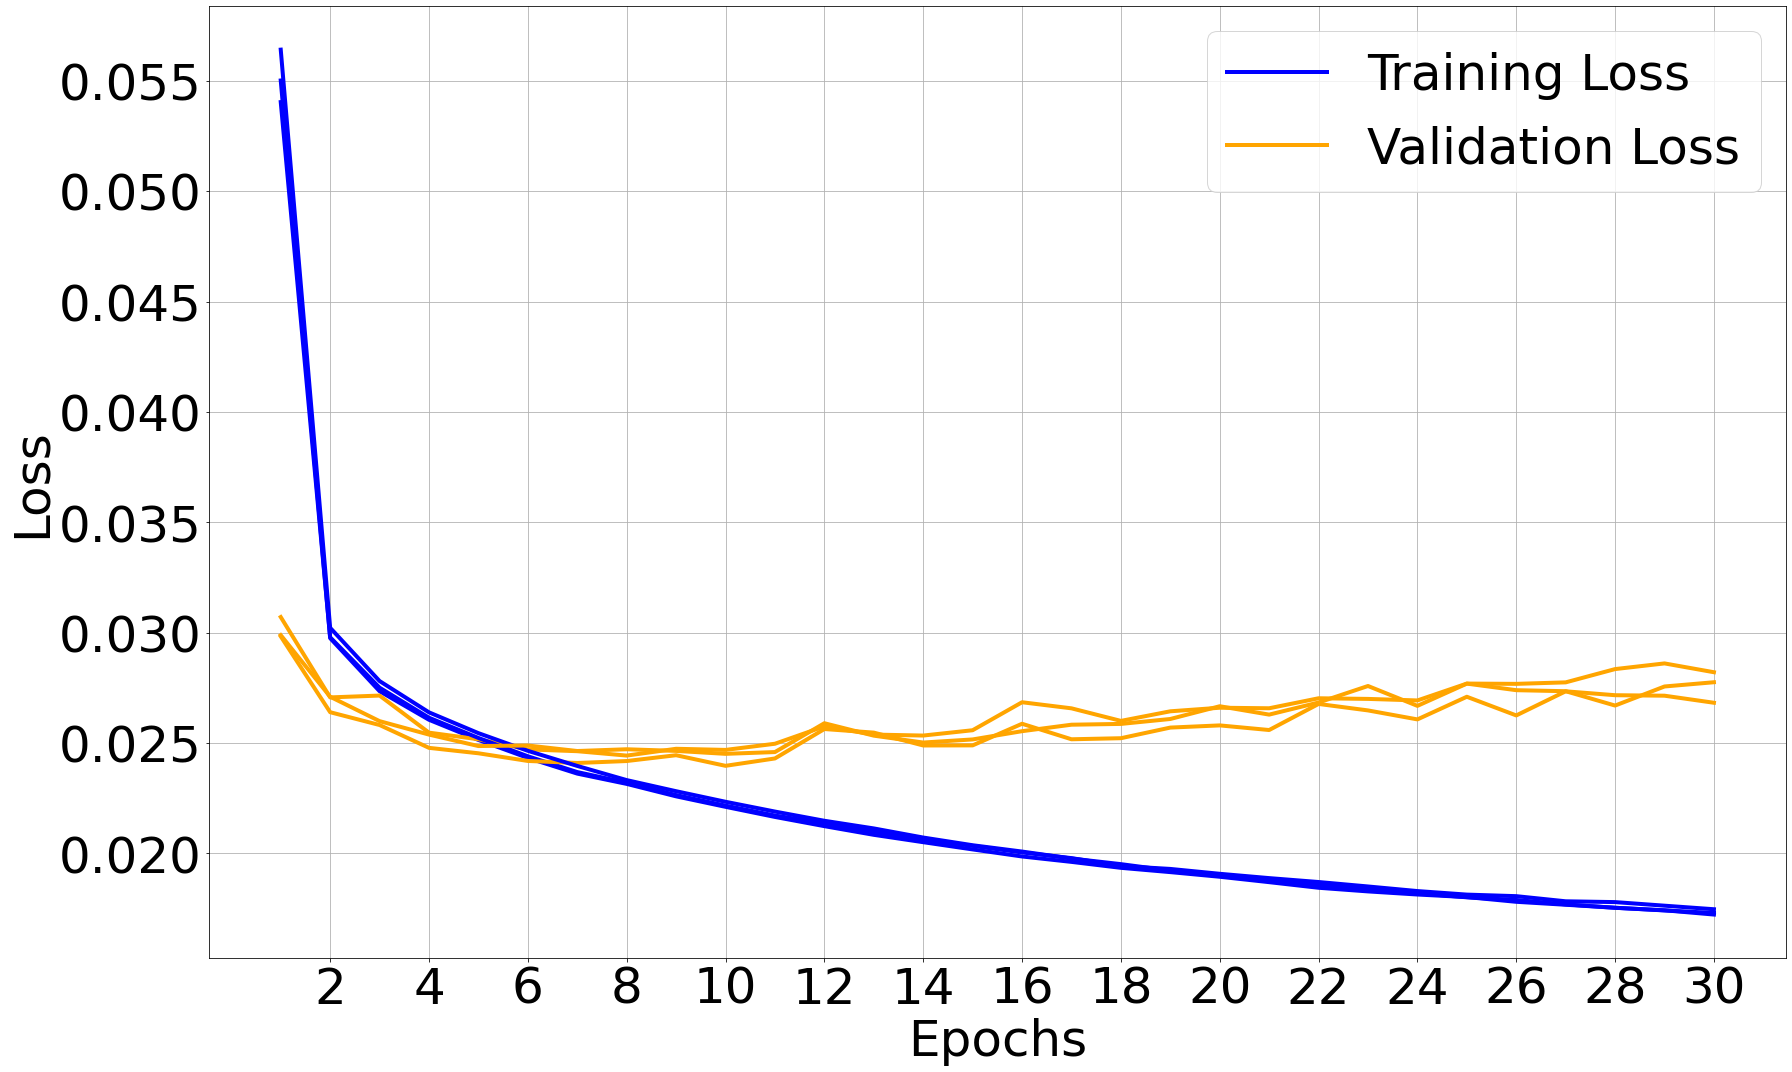

In [25]:
make_plot(f1_plot, val_f1_plot, 'F1 Score')
make_plot(precision_plot, val_precision_plot, 'Precision Score')
make_plot(recall_plot, val_recall_plot, 'Recall Score')
make_plot(loss_plot, val_loss_plot, 'Loss')

After knowing that the optimal epoch is 12, we train the full model on the entire train data

In [26]:
tf.random.set_seed(42)
with tpu_strategy.scope(): 
    final_lstm_model = build_bert_lstm_model()

In [27]:
final_lstm_model.fit((train_seq, train_mask), train_labels, epochs = 12, batch_size = 64, verbose=0)

In [28]:
final_lstm_model.evaluate((test_seq, test_mask), test_labels)

272/272 [==============================] - 31s 63ms/step - loss: 0.0236 - f1: 0.7646 - precision: 0.7805 - recall: 0.7504


[0.02358771115541458,
 0.7645752429962158,
 0.780540406703949,
 0.7504368424415588]

## An example by merging word pieces

this is done by merging word pieces that begin with "##" with the previous word pieces

In [29]:
test_pred = np.array(final_lstm_model.predict((test_seq, test_mask)))
example_sentence = test_sentences[2021]
example_tokens = scibert_tokenizer.convert_ids_to_tokens(test_seq[2021])
example_mask = test_mask[2021]
example_detect_gold = np.argmax(test_labels[2021], axis=-1)
example_recog_gold = test_recog_labels[2021]
example_detect_pred = np.argmax(test_pred[2021], axis=-1)
example_detect_pred_prob = np.max(test_pred[2021], axis=-1)


def merge_subwords(sent_tokens, sent_det_pred, sent_det_gold, sent_rec_gold, sent_det_pred_prob):
    new_tokens, gold_det_labels, gold_rec_labels, predicted_det_labels, predicted_det_probs = [], [], [], [], []
    for token, det_label_hat, det_label, rec_label, det_prob in zip(sent_tokens, 
                                                          sent_det_pred, 
                                                          sent_det_gold, 
                                                          sent_rec_gold,
                                                          sent_det_pred_prob):
        if token != "[PAD]":
            if token.startswith("##"):
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                predicted_det_labels.append(inv_label_map[det_label_hat])
                gold_det_labels.append(inv_label_map[det_label])
                gold_rec_labels.append(rec_label)
                predicted_det_probs.append(det_prob)
                new_tokens.append(token)
                
    return new_tokens, gold_det_labels, gold_rec_labels, predicted_det_labels, predicted_det_probs

(new_tokens, 
 gold_det_labels, 
 gold_rec_labels, 
 predicted_det_labels,
 predicted_det_probs) = merge_subwords(example_tokens, 
                                        example_detect_pred, 
                                        example_detect_gold,
                                        example_recog_gold,
                                        example_detect_pred_prob)

print("{0:30} {1:20} {2:20} {3:30} {4:20}".format('Token', 'Detection Gold', 'Detection Prediction', 'Recognition Gold', "prob"))
print("{0:30} {1:20} {2:20} {3:30} {4:20}".format('_____', '______________', '____________________', '________________', "____"))

for token, det_label, rec_label, label_hat, prob in zip(new_tokens, gold_det_labels, gold_rec_labels, predicted_det_labels, predicted_det_probs):
    print("{0:30} {1:20} {2:20} {3:20} {4:20}".format(token, det_label, label_hat, rec_label, prob))  

Token                          Detection Gold       Detection Prediction Recognition Gold               prob                
_____                          ______________       ____________________ ________________               ____                
[CLS]                          O                    O                    O                      0.9999992847442627
in                             O                    O                    O                      0.9999282360076904
fact                           O                    O                    O                      0.9986149072647095
,                              O                    O                    O                       0.999976634979248
both                           O                    O                    O                      0.9999467134475708
the                            O                    O                    O                       0.999947190284729
resistive                      O                    O       

## Merge Entities

Merge B-Entity and I-Entity to form Entity

In [30]:
def merge_entities(sent_tokens, sent_pred, sent_gold, sent_recog_gold, sent_det_prob):
    (new_tokens, 
     gold_det_labels, 
     gold_rec_labels, 
     predicted_det_labels,
     predicted_det_prob) = merge_subwords(sent_tokens, 
                                            sent_pred, 
                                            sent_gold,
                                            sent_recog_gold,
                                            sent_det_prob)
    
    merged_tokens = copy.copy(new_tokens)
    chunks_pred = get_entities(predicted_det_labels)
    det_preds = ["O"]*len(new_tokens)
    
    shift = 0
    for i, (chunk_type, chunk_start, chunk_end) in enumerate(chunks_pred):
        repeat = chunk_end - chunk_start + 1
        merged_tokens[chunk_start:chunk_end+1] = [' '.join(merged_tokens[chunk_start:chunk_end+1])]*repeat
        det_preds[chunk_start:chunk_end+1] = [chunk_type]*repeat

    return new_tokens, merged_tokens, gold_rec_labels, predicted_det_labels, predicted_det_prob

- Saving the entire test data groundtruth and predictions with softmax probability into alist

- This is intensive process as it requires to merge the subwords and words into entities

In [31]:
test_pred = np.argmax(final_lstm_model.predict((test_seq, test_mask)), axis=-1)
test_prob = np.max(final_lstm_model.predict((test_seq, test_mask)), axis=-1)
test_true = np.argmax(test_labels, axis=-1)

test_seq_predictions = []

for seq, seq_pred, seq_gold, seq_rec_gold, prob in zip(tqdm(test_seq), test_pred, test_true, test_recog_labels, test_prob):
    seq = scibert_tokenizer.convert_ids_to_tokens(seq)
    test_seq_predictions.append(merge_entities(seq, seq_pred, seq_gold, seq_rec_gold, prob))

100%|██████████| 8687/8687 [1:12:35<00:00,  1.99it/s]


In [32]:
train_pred = np.argmax(final_lstm_model.predict((train_seq, train_mask)), axis=-1)
train_prob = np.max(final_lstm_model.predict((train_seq, train_mask)), axis=-1)
train_true = np.argmax(train_labels, axis=-1)

train_seq_predictions = []

(train_seq_portion, 
 train_pred_portion, 
 train_true_portion, 
 train_rec_gold_portion,
 train_prob_portion) = (
    train_seq[:3000], 
    train_pred[:3000], 
    train_true[:3000], 
    train_recog_labels[:3000],
    train_prob[:3000])

for seq, seq_pred, seq_gold, seq_rec_gold, prob  in zip(tqdm(train_seq_portion), 
                                                        train_pred_portion, 
                                                        train_true_portion, 
                                                        train_rec_gold_portion, 
                                                        train_prob_portion):
    seq = scibert_tokenizer.convert_ids_to_tokens(seq)
    train_seq_predictions.append(merge_entities(seq, seq_pred, seq_gold, seq_rec_gold, prob))

100%|██████████| 3000/3000 [25:08<00:00,  1.99it/s]


## Saving predictions to csv

This csv is going to be used for the second step

In [33]:
def extract_rows(predictions):
    rows = []
    for seq, merged_seq, seq_pred, seq_gold, det_prob in predictions:
        for entity, merged, entity_pred, gold, prob in zip(seq, merged_seq, seq_pred, seq_gold, det_prob):
            rows.append([entity, entity_pred, merged, gold, prob])
    return rows

test_rows = extract_rows(test_seq_predictions)
train_rows = extract_rows(train_seq_predictions)

In [34]:
def save_csv(rows, name):
    fields = ['Tokens', 'Gold Label', 'Span', 'Detection Prediction', 'Detect Prob']     
    with open(name+'.csv', 'w') as f: 
        write = csv.writer(f) 
        write.writerow(fields) 
        write.writerows(rows) 

save_csv(test_rows, 'test_prediction_scibert')
save_csv(train_rows, 'train_prediction_scibert')

## Refereneces

https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/

https://laptrinhx.com/entity-level-evaluation-for-ner-task-2422422827/

http://www.davidsbatista.net/blog/2018/05/09/Named_Entity_Evaluation/

https://albertauyeung.github.io/2020/06/19/bert-tokenization.html